#Introduction: PoliticEs 2022

This shared task aims to extract political ideology information from texts. For this, an author profiling task is proposed. It is focused on the identification of the gender, the profession, and the political spectrum from a binary and multi-class perspective. More info in https://codalab.lisn.upsaclay.fr/competitions/1948

### Enviroment Setup

- Set up working directory
- Installation of libraries

In [2]:
from google.colab import drive

drive.mount("/content/drive/")
sst_home = 'drive/My Drive/Colab Notebooks/PoliticES/'

Mounted at /content/drive/


In [ ]:
!pip install transformers 
!pip install tokenizers 

%tensorflow_version 2.x

!pip install pandas
!pip install numpy
!pip install sklearn
!pip install tensorflow
!pip install matplotlib

import tensorflow as tf
print('TensorFlow:', tf.__version__)

### Auxiliary Functions

- transform_dataframe: Group in the dataframe the different tweets per user to create a single document/record per user.
- group_tweets: It groups in the dataframe the different tweets per user in blocks of tweets that do not exceed a previously established maximum number of tokens.

In [4]:
import random
import pandas as pd

def transform_dataframe(df_):
  df = df_.copy()
  df['tweet'] = df.groupby(['label'])['tweet'].transform(lambda x : ' '.join(x))
  return df[df.columns[1:]].drop_duplicates()

def group_tweets(df, tokenizers, max_tokens = 510, test = False):
  new_data = []
  users = list(df['label'].unique())
  for user in users:
    user_tweets = df[df['label'].isin([user])]
    tweets = user_tweets['tweet'].values
    random.shuffle(tweets)
    num_tokens = 0
    samples = []
    for tweet in tweets:
      max_tokens_tweet = max([len(tokenizer.encode(tweet)) for tokenizer in tokenizers])
      if (num_tokens + max_tokens_tweet > max_tokens):
        tweet_sample = ' '.join(samples)
        if not test:
          new_data.append({'label': user, 'gender': user_tweets['gender'].values[0], 'profession': user_tweets['profession'].values[0], 'ideology_binary': user_tweets['ideology_binary'].values[0], 'ideology_multiclass': user_tweets['ideology_multiclass'].values[0], 'tweet': tweet_sample})
        else:
          new_data.append({'label': user, 'tweet': tweet_sample})
        num_tokens = max_tokens_tweet
        samples = [tweet]
      else:
        num_tokens = num_tokens + max_tokens_tweet
        samples.append(tweet)
    
    if num_tokens > 0:
      tweet_sample = ' '.join(samples)
      if not test:
        new_data.append({'label': user, 'gender': user_tweets['gender'].values[0], 'profession': user_tweets['profession'].values[0], 'ideology_binary': user_tweets['ideology_binary'].values[0], 'ideology_multiclass': user_tweets['ideology_multiclass'].values[0], 'tweet': tweet_sample})
      else:
        new_data.append({'label': user, 'tweet': tweet_sample})
  return new_data

## Training Data Exploration
This section explores the data provided by the organization.

The dataset provided contains tweets from different users selected along Spanish goverment members, Spanish Congress and Senate members, mayors of some important cities in Spain, some autonomous communities presidents, former politicians, collaborators affiliated with political parties and finally, different Spanish news media journalists. Each tweet was labelled with his author’s gender (male and female), profession (politician and journalist) and political spectrum on two axes: binary (left and right) and multiclass (left, moderate left, moderate right and right).

In [ ]:
import pandas as pd

df = pd.read_csv(sst_home + 'training.csv')
df_grouped = transform_dataframe(df)

The dataset consists of a total of 313 unique users and 120 tweets per user.

In [ ]:
df.groupby('label')['tweet'].count().describe()

count    313.0
mean     120.0
std        0.0
min      120.0
25%      120.0
50%      120.0
75%      120.0
max      120.0
Name: tweet, dtype: float64

In [ ]:
df.head(5)

Unnamed: 0   label gender  profession ideology_binary ideology_multiclass  \
0       42699  @user1   male  politician            left       moderate_left   
1       24576  @user1   male  politician            left       moderate_left   
2       28121  @user1   male  politician            left       moderate_left   
3       48905  @user1   male  politician            left       moderate_left   
4       34111  @user1   male  politician            left       moderate_left   

                                               tweet  
0  ¿ Quien miente [POLITICAL_PARTY] o C’s ? ¿ O a...  
1  Sin normas dejaron que crecieran las VTC y Sin...  
2  Hoy se habla de fiscalidad justa en #Congreso....  
3  👉🏻[POLITICAL_PARTY] dictó instrucción en 2012 ...  
4  Por la mañana venden un plan de detección ¿pre...

In [ ]:
df.describe()

Unnamed: 0
count  37560.000000
mean   25256.682641
std    14631.480049
min        0.000000
25%    12550.750000
50%    25208.500000
75%    37958.250000
max    50638.000000

Gender | Male | Female
--- | --- | --- 
Users | 177 | 137 

In [ ]:
df_grouped.gender.value_counts()

male      177
female    137
Name: gender, dtype: int64

Profession | Politician | Journalist
--- | --- | --- 
Users | 252 | 62 

In [ ]:
df_grouped.profession.value_counts()

politician    252
journalist     62
Name: profession, dtype: int64

Ideology Binary | Left | Right
--- | --- | --- 
Users | 178 | 136 

In [ ]:
df_grouped.ideology_binary.value_counts()

left     178
right    136
Name: ideology_binary, dtype: int64

Ideology Multiclass | Left | Moderate Left | Moderate Right | Right
--- | --- | ---  | ---  | --- 
Users | 76 | 102 | 94 | 42

In [ ]:
df_grouped.ideology_multiclass.value_counts()

moderate_left     102
moderate_right     94
left               76
right              42
Name: ideology_multiclass, dtype: int64

Words/Tweet | Mean | Std | Min | Max
--- | --- | ---  | ---  | --- 
 | 41.37 | 11.27 | 1 | 91

In [ ]:
df['words'] = [len(x.split()) for x in df['tweet'].tolist()]
df['words'].describe()

count    37560.000000
mean        41.377662
std         11.272500
min          1.000000
25%         38.000000
50%         45.000000
75%         49.000000
max         91.000000
Name: words, dtype: float64

Distribution of words in each tweet

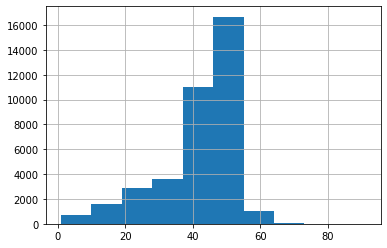

In [ ]:
df.tweet.str.split().\
    map(lambda x: len(x)).\
    hist()

In [ ]:
import re

NO_WORDS = ['POLITICAL_PARTY', 'user', '@user', '[POLITICAL_PARTY]']

wordList = list()
for i in df.tweet.values:
    for token in nlp(i):
        if (not token.is_stop) and (not token.text in NO_WORDS) and (not token.is_punct):
          wordList.append(token.text)

gender_wordList = dict()
for gender in ['male', 'female']:
  new_wl = list()
  for i in df[df['gender'] == gender].tweet.values:
      for token in nlp(i):
        if (not token.is_stop) and (not token.text in NO_WORDS):
          new_wl.append(token.text)
  gender_wordList[gender] = new_wl

profession_wordList = dict()
for profession in ['journalist', 'politician']:
  new_wl = list()
  for i in df[df['profession'] == profession].tweet.values:
      for token in nlp(i):
        if (not token.is_stop) and (not token.text in NO_WORDS):
          new_wl.append(token.text)
  profession_wordList[profession] = new_wl

ideology_wordList = dict()
for ideology in ['left', 'right']:
  new_wl = list()
  for i in df[df['ideology_binary'] == ideology].tweet.values:
      for token in nlp(i):
        if (not token.is_stop) and (not token.text in NO_WORDS):
          new_wl.append(token.text)
  ideology_wordList[ideology] = new_wl

ideology_multiclass_wordList = dict()
for ideology in ['left', 'moderate_left', 'moderate_right', 'right']:
  new_wl = list()
  for i in df[df['ideology_multiclass'] == ideology].tweet.values:
      for token in nlp(i):
        if (not token.is_stop) and (not token.text in NO_WORDS):
          new_wl.append(token.text)
  ideology_multiclass_wordList[ideology] = new_wl

### Total Word Cloud

Wordcloud with the most relevant words from all tweets

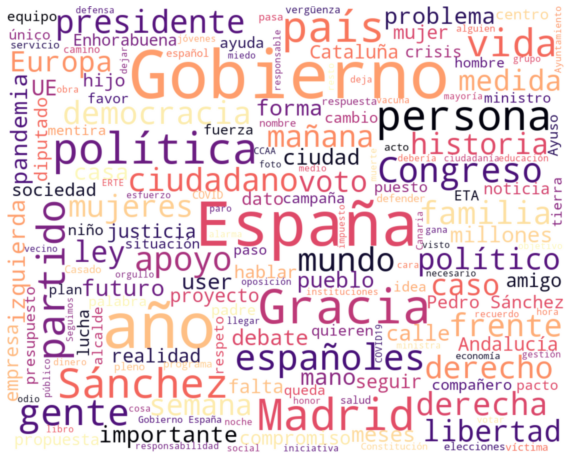

In [ ]:
import matplotlib.pyplot as plt
        
# Let us take a look at the most frequently used word in the reviews
from wordcloud import WordCloud
word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = 'magma', 
                       margin = 0,
                       max_words = 183,  
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "white").generate(" ".join(wordList))

plt.figure(figsize = (10, 15))
plt.imshow(word_cloud, interpolation = "gaussian")
plt.axis("off")
plt.show()

### Gender Wordcloud
Wordcloud with the most relevant words by gender

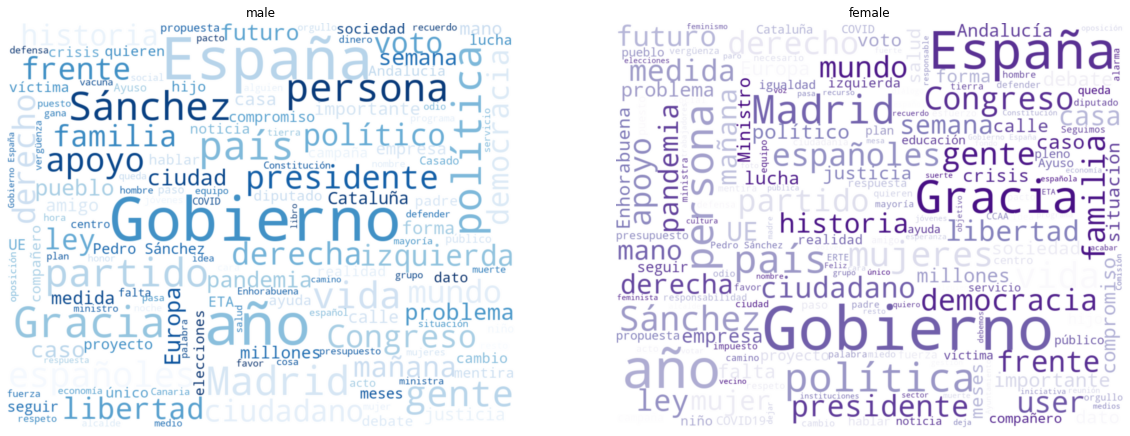

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(20,20))

colormaps = ['Blues', 'Purples']
for i, gender in enumerate(['male', 'female']):
  word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = colormaps[i], 
                       margin = 0,
                       max_words = 183,  
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "white").generate(" ".join(gender_wordList[gender]))

  axis[i].imshow(word_cloud, interpolation = "gaussian")
  axis[i].axis("off")
  axis[i].set_title(gender)

### Profession Wordcloud
Wordcloud with the most relevant words by profession

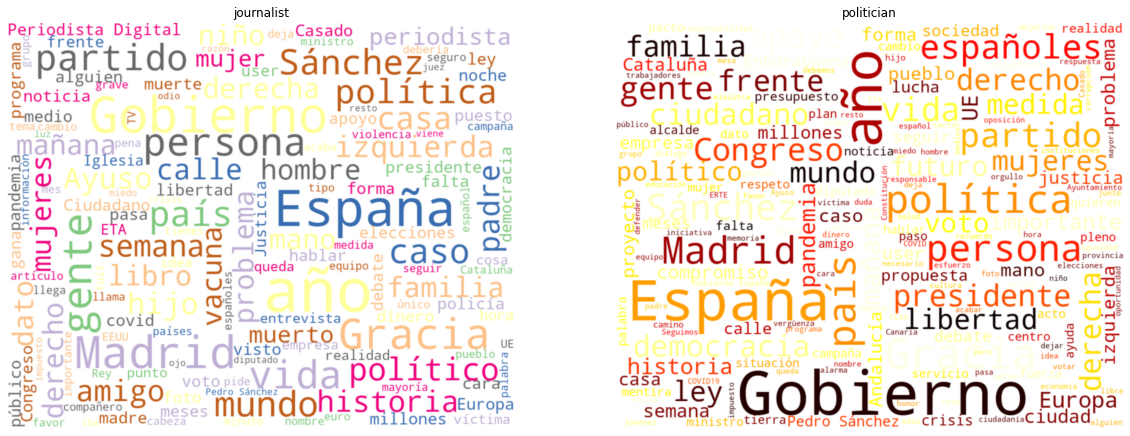

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(20,20))
colormaps = ['Accent', 'hot']
for i, profession in enumerate(['journalist', 'politician']):
  word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = colormaps[i], 
                       margin = 0,
                       max_words = 183,  
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "white").generate(" ".join(profession_wordList[profession]))

  axis[i].imshow(word_cloud, interpolation = "gaussian")
  axis[i].axis("off")
  axis[i].set_title(profession)

### Binary Ideology Wordcloud
Wordcloud with the most relevant words by binary ideology

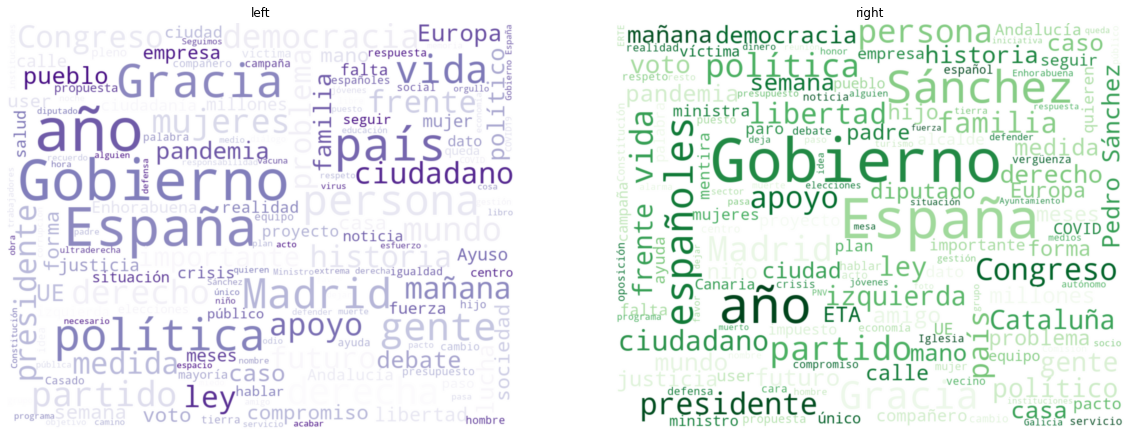

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(20,20))
colormaps = ['Purples', 'Greens']
for i, ideology in enumerate(['left', 'right']):
  word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = colormaps[i], 
                       margin = 0,
                       max_words = 183,  
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "white").generate(" ".join(ideology_wordList[ideology]))

  axis[i].imshow(word_cloud, interpolation = "gaussian")
  axis[i].axis("off")
  axis[i].set_title(ideology)

### Profession Wordcloud
Wordcloud with the most relevant words by multiclass profession

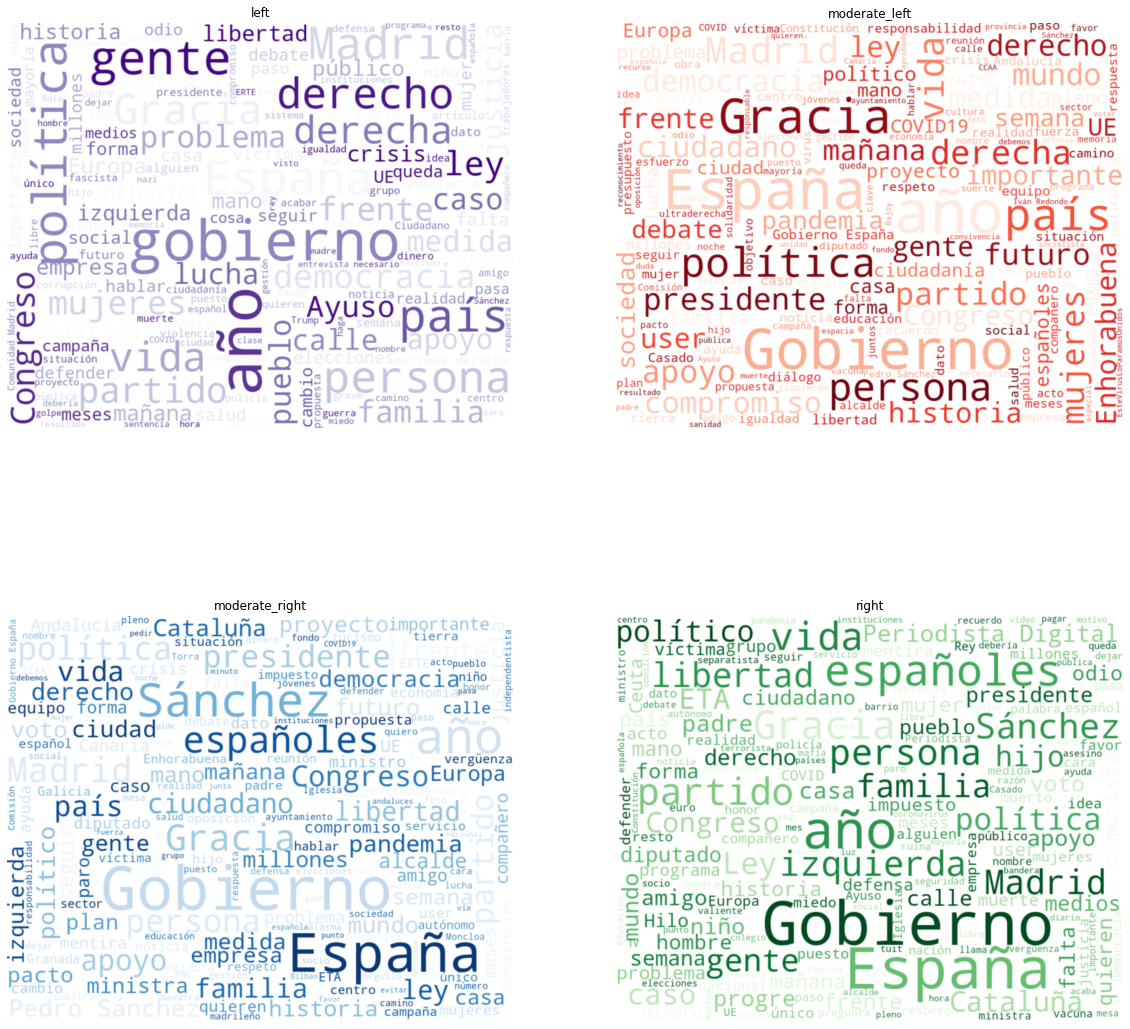

In [ ]:
figure, axis = plt.subplots(2, 2, figsize=(20,20))
colormaps = ['Purples', 'Reds', 'Blues', 'Greens']
for i, ideology in enumerate(['left', 'moderate_left', 'moderate_right', 'right']):
  word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = colormaps[i], 
                       margin = 0,
                       max_words = 183,  
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "white").generate(" ".join(ideology_multiclass_wordList[ideology]))
  plt.subplot(2,2,i + 1)
  plt.imshow(word_cloud, interpolation = "gaussian")
  plt.axis("off")
  plt.title(ideology)

## Custom Dataset Data Exploration
This section contains the data exploration of the dataset developed by our team during the competition.

During our participation in PoliticEs 2022, it was decided to extend the original dataset, collecting tweets from Spanish politicians and journalists posted between January 2021 and February 2022.

As a result, 361,646 different tweets were obtained from a total of 430 unique users. Due to the anonymization of users in the original dataset, it cannot be assured that there are no repeat users. However, since the publication date of the tweets in the dataset provided by the organization is 2020 and that of the tweets collected by our team is 2021 and 2022, it is guaranteed that the new data were not present in the original corpus. An important difference from the original data is that the number of tweets per user is not fixed and varies from user to user.

In [ ]:
import pandas as pd

df = pd.read_csv('drive/My Drive/Colab Notebooks/PoliticES/outputs/ScrappedTweets.csv')
df_group = transform_dataframe(df)

In [ ]:
df

label gender  profession ideology_binary ideology_multiclass  \
0         marianorajoy   male  politician           right      moderate_right   
1         marianorajoy   male  politician           right      moderate_right   
2         marianorajoy   male  politician           right      moderate_right   
3         marianorajoy   male  politician           right      moderate_right   
4         marianorajoy   male  politician           right      moderate_right   
...                ...    ...         ...             ...                 ...   
361641  ramonepiscopal   male  politician           right      moderate_right   
361642  ramonepiscopal   male  politician           right      moderate_right   
361643  ramonepiscopal   male  politician           right      moderate_right   
361644  ramonepiscopal   male  politician           right      moderate_right   
361645  ramonepiscopal   male  politician           right      moderate_right   

                                                    tweet  
0       Lamento profundamente el fallecimiento de Davi...  
1       Hace seis años cambiamos de página pero seguim...  
2       Participar en el Foro La Toja es siempre un mo...  
3       Comparto con vosotros el comunicado que acabo ...  
4       Ha fallecido \n@user\n , un hombre generoso y ...  
...                                                   ...  
361641  Las prohibiciones tienen que llegar aparejadas...  
361642  Lo del hospital de Toledo es inaceptable, irre...  
361643  El trabajo de la oposición está siendo más efi...  
361644  La Ley Celaa es un ERROR DEMOCRÁTICO porque at...  
361645  Paco Nuñez es sin duda uno de los políticos co...  

[361646 rows x 6 columns]

In [ ]:
df.groupby('label')['tweet'].count().describe()

count     430.000000
mean      841.037209
std      1033.050755
min         1.000000
25%       144.250000
50%       475.500000
75%      1058.000000
max      6944.000000
Name: tweet, dtype: float64

In [ ]:
df.describe()

label  gender  profession ideology_binary ideology_multiclass  \
count     361646  361646      361646          361646              361646   
unique       430       2           2               2                   4   
top     xdelucas    male  politician           right      moderate_right   
freq        6944  227422      329399          188661              114751   

                                                    tweet  
count                                              361646  
unique                                             360814  
top     [POLITICAL_PARTY]\n\n[POLITICAL_PARTY]\n\n[POL...  
freq                                                   24

Gender | Male | Female
--- | --- | --- 
Users | 246 | 184 
Tweets | 227422 | 134224

In [ ]:
df_group.gender.value_counts()

male      246
female    184
Name: gender, dtype: int64

In [ ]:
df.gender.value_counts()

male      227422
female    134224
Name: gender, dtype: int64

Profession | Politician | Journalist
--- | --- | --- 
Users | 415 | 15
Tweets | 329399 | 32247 

In [ ]:
df_group.profession.value_counts()

politician    415
journalist     15
Name: profession, dtype: int64

In [ ]:
df.profession.value_counts()

politician    329399
journalist     32247
Name: profession, dtype: int64

Ideology Binary | Left | Female
--- | --- | --- 
Users | 229 | 201 
Tweets | 188661 | 172985

In [ ]:
df_group.ideology_binary.value_counts()

left     229
right    201
Name: ideology_binary, dtype: int64

In [ ]:
df.ideology_binary.value_counts()

right    188661
left     172985
Name: ideology_binary, dtype: int64

Ideology Multiclass | Left | Moderate Left | Moderate Right | Right
--- | --- | ---  | ---  | --- 
Users | 160 | 145 | 71 | 54
Tweets | 114751 | 94764 | 79219 | 72921

In [ ]:
df_group.ideology_multiclass.value_counts()

moderate_left     160
moderate_right    145
left               71
right              54
Name: ideology_multiclass, dtype: int64

In [ ]:
df.ideology_multiclass.value_counts()

moderate_right    114751
moderate_left      94764
left               79219
right              72912
Name: ideology_multiclass, dtype: int64

Words/Tweet | Mean | Std | Min | Max
--- | --- | ---  | ---  | --- 
 | 29.72 | 12.28 | 2 | 65

In [ ]:
df['words'] = [len(x.split()) for x in df['tweet'].tolist()]
df['words'].describe()

count    361646.000000
mean         29.721899
std          12.287670
min           2.000000
25%          19.000000
50%          31.000000
75%          41.000000
max          65.000000
Name: words, dtype: float64

Distribution of words in each tweet

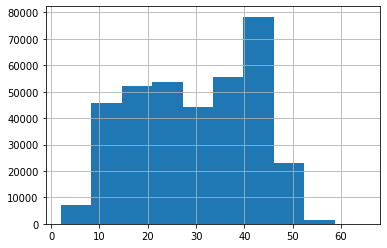

In [ ]:
df.tweet.str.split().\
    map(lambda x: len(x)).\
    hist()

In [ ]:
import re

NO_WORDS = ['POLITICAL_PARTY', 'user', '@user', '[POLITICAL_PARTY]']

wordList = list()
for i in df.tweet.values:
    for token in nlp(i):
        if (not token.is_stop) and (not token.text in NO_WORDS) and (not token.is_punct):
          wordList.append(token.text)

gender_wordList = dict()
for gender in ['male', 'female']:
  new_wl = list()
  for i in df[df['gender'] == gender].tweet.values:
      for token in nlp(i):
        if (not token.is_stop) and (not token.text in NO_WORDS):
          new_wl.append(token.text)
  gender_wordList[gender] = new_wl

profession_wordList = dict()
for profession in ['journalist', 'politician']:
  new_wl = list()
  for i in df[df['profession'] == profession].tweet.values:
      for token in nlp(i):
        if (not token.is_stop) and (not token.text in NO_WORDS):
          new_wl.append(token.text)
  profession_wordList[profession] = new_wl

ideology_wordList = dict()
for ideology in ['left', 'right']:
  new_wl = list()
  for i in df[df['ideology_binary'] == ideology].tweet.values:
      for token in nlp(i):
        if (not token.is_stop) and (not token.text in NO_WORDS):
          new_wl.append(token.text)
  ideology_wordList[ideology] = new_wl

ideology_multiclass_wordList = dict()
for ideology in ['left', 'moderate_left', 'moderate_right', 'right']:
  new_wl = list()
  for i in df[df['ideology_multiclass'] == ideology].tweet.values:
      for token in nlp(i):
        if (not token.is_stop) and (not token.text in NO_WORDS):
          new_wl.append(token.text)
  ideology_multiclass_wordList[ideology] = new_wl

### Total Word Cloud

Wordcloud with the most relevant words from all tweets

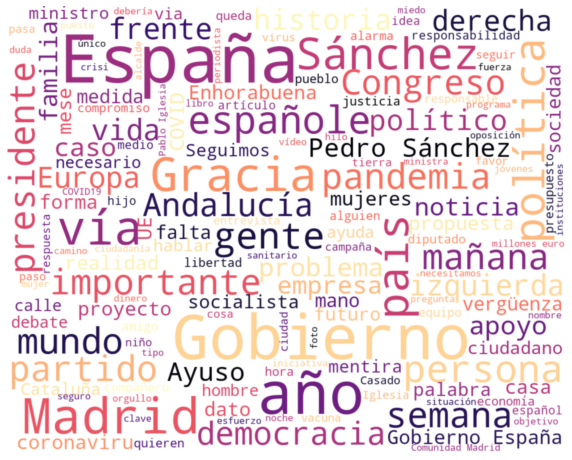

In [ ]:
import matplotlib.pyplot as plt
        
# Let us take a look at the most frequently used word in the reviews
from wordcloud import WordCloud
word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = 'magma', 
                       margin = 0,
                       max_words = 183,  
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "white").generate(" ".join(wordList))

plt.figure(figsize = (10, 15))
plt.imshow(word_cloud, interpolation = "gaussian")
plt.axis("off")
plt.show()

### Gender Wordcloud
Wordcloud with the most relevant words by gender

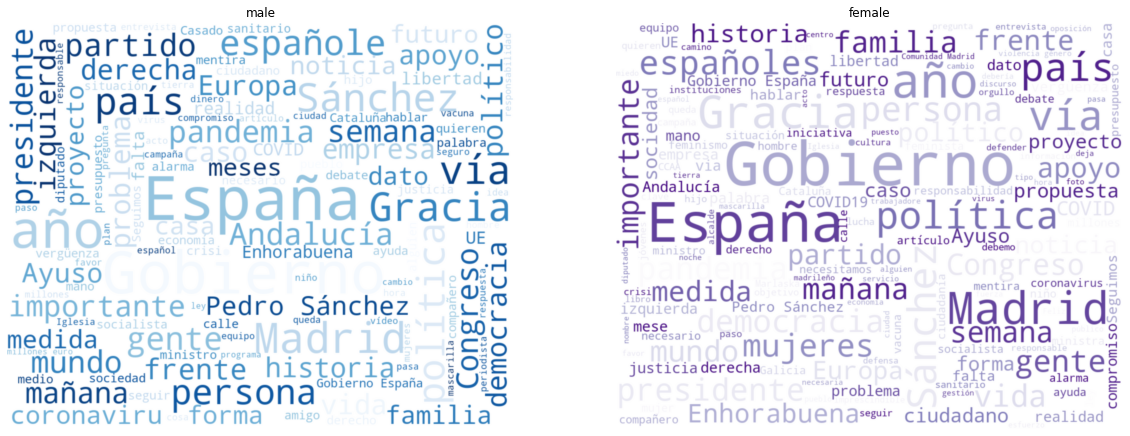

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(20,20))

colormaps = ['Blues', 'Purples']
for i, gender in enumerate(['male', 'female']):
  word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = colormaps[i], 
                       margin = 0,
                       max_words = 183,  
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "white").generate(" ".join(gender_wordList[gender]))

  axis[i].imshow(word_cloud, interpolation = "gaussian")
  axis[i].axis("off")
  axis[i].set_title(gender)

### Profession Wordcloud
Wordcloud with the most relevant words by profession

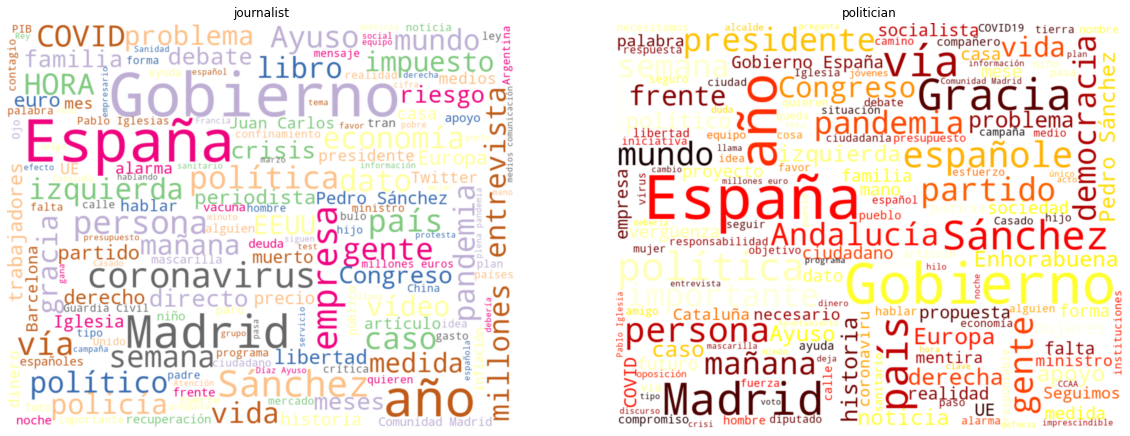

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(20,20))
colormaps = ['Accent', 'hot']
for i, profession in enumerate(['journalist', 'politician']):
  word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = colormaps[i], 
                       margin = 0,
                       max_words = 183,  
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "white").generate(" ".join(profession_wordList[profession]))

  axis[i].imshow(word_cloud, interpolation = "gaussian")
  axis[i].axis("off")
  axis[i].set_title(profession)

### Binary Ideology Wordcloud
Wordcloud with the most relevant words by binary ideology

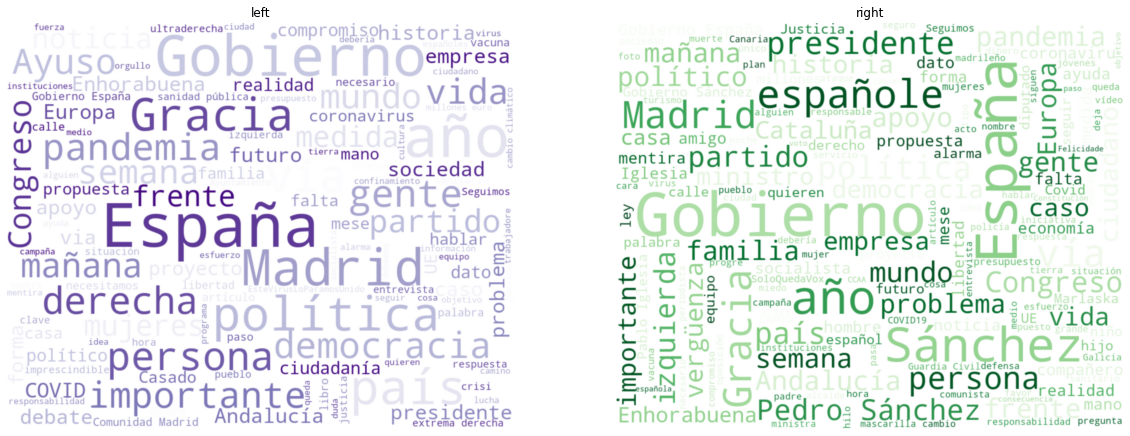

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(20,20))
colormaps = ['Purples', 'Greens']
for i, ideology in enumerate(['left', 'right']):
  word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = colormaps[i], 
                       margin = 0,
                       max_words = 183,  
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "white").generate(" ".join(ideology_wordList[ideology]))

  axis[i].imshow(word_cloud, interpolation = "gaussian")
  axis[i].axis("off")
  axis[i].set_title(ideology)

### Multiclass Ideology Wordcloud
Wordcloud with the most relevant words by multiclass ideology

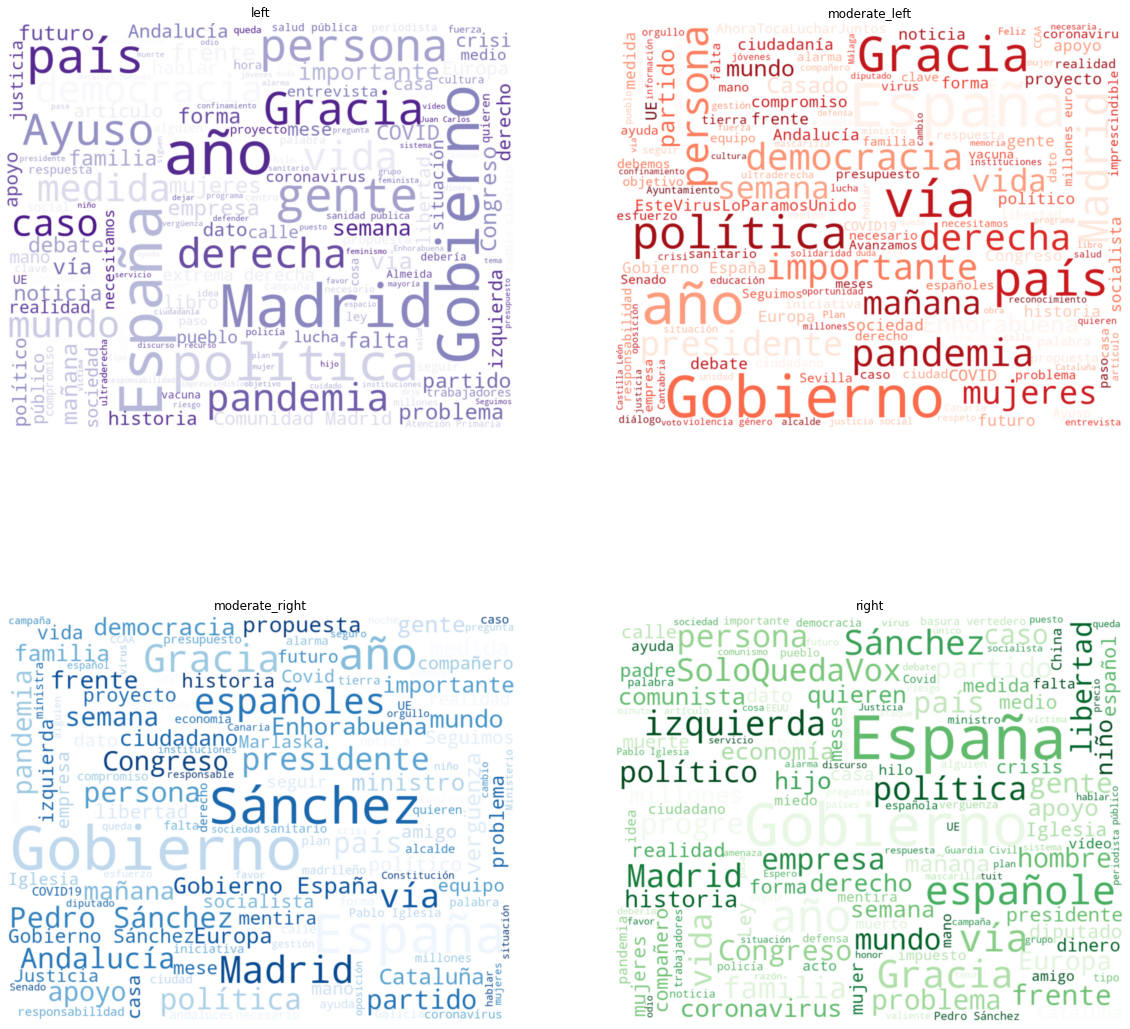

In [ ]:
figure, axis = plt.subplots(2, 2, figsize=(20,20))
colormaps = ['Purples', 'Reds', 'Blues', 'Greens']
for i, ideology in enumerate(['left', 'moderate_left', 'moderate_right', 'right']):
  word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = colormaps[i], 
                       margin = 0,
                       max_words = 183,  
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "white").generate(" ".join(ideology_multiclass_wordList[ideology]))
  plt.subplot(2,2,i + 1)
  plt.imshow(word_cloud, interpolation = "gaussian")
  plt.axis("off")
  plt.title(ideology)

# Build the model

Proposed system for the author profiling task is based on the fine-tuning of the combination of two pre-trained transformer-based models.

## BETO Set up

The first one, BETO is the first Spanish BERT-based and has demonstrated its performance in a large multitude of different NLP tasks.

In [5]:
from transformers import BertTokenizer
tokenizer_bert = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

Downloading:   0%|          | 0.00/236k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/364 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

## MarIA Set Up
The second, MarIA, is a recently presented RoBERTa-based model that has been pretrained using a massive corpus of 570GB of clean and deduplicated texts with 135 billion words extracted from the Spanish Web Archive crawled by the National Library of Spain between 2009 and 2019.

In [6]:
from transformers import RobertaTokenizer
tokenizer_maria = RobertaTokenizer.from_pretrained("PlanTL-GOB-ES/roberta-base-bne")

Downloading:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/497k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/613 [00:00<?, ?B/s]

## Model Creation

User tweets are transformed into tokens that feed BETO and MarIA. From the classification token known as [CLS], each model generates a 768-dimensional vector representing the meaning of the entire sentence. Both vectors are concatenated and the result serves as input to four separate classification blocks, one for each classification task (gender, profession, binary ideology and multiclass ideology). Each classification block is formed by fully connected dense layer with 768 units and 𝑡𝑎𝑛ℎ activation function that directly connects with linear layer with a softmax or sigmoid activation on top, which returns a probability score for each class. Dropout for regularization, with probability of 0.15 to prevent overfitting, is applied after BETO, MarIA and the fully connected dense layers.

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from tensorflow.keras import layers
from transformers import TFBertModel
from transformers import TFRobertaModel

max_len = 512

def create_model():
    ## BERT encoder
    encoder_MARIA = TFRobertaModel.from_pretrained('PlanTL-GOB-ES/roberta-base-bne', from_pt=True)
    encoder_BERT = TFBertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-cased', from_pt=True)

    ### INPUTS BERT
    input_ids_BERT = layers.Input(shape=(max_len,), dtype=tf.int32)
    token_type_ids_BERT = layers.Input(shape=(max_len,), dtype=tf.int32)
    attention_mask_BERT = layers.Input(shape=(max_len,), dtype=tf.int32)
    embedding_BERT = encoder_BERT(
        input_ids_BERT, token_type_ids=token_type_ids_BERT, attention_mask=attention_mask_BERT
    )['pooler_output']

    embedding_BERT = layers.Dropout(0.15)(embedding_BERT)

    input_ids_MARIA = layers.Input(shape=(max_len,), dtype=tf.int32)
    token_type_ids_MARIA = layers.Input(shape=(max_len,), dtype=tf.int32)
    attention_mask_MARIA = layers.Input(shape=(max_len,), dtype=tf.int32)
    embedding_MARIA = encoder_MARIA(
        input_ids_MARIA, token_type_ids=token_type_ids_MARIA, attention_mask=attention_mask_MARIA
    )['pooler_output']

    embedding_MARIA = layers.Dropout(0.15)(embedding_MARIA)

    embedding = layers.Concatenate()([embedding_BERT, embedding_MARIA])

    x_gender = layers.Dense(units=768)(embedding)
    x_gender = layers.Activation("tanh")(x_gender)
    x_gender = layers.Dropout(0.15)(x_gender)

    x_ideology = layers.Dense(units=768)(embedding)
    x_ideology = layers.Activation("tanh")(x_ideology)
    x_ideology = layers.Dropout(0.15)(x_ideology)

    x_profession = layers.Dense(units=768)(embedding)
    x_profession = layers.Activation("tanh")(x_profession)
    x_profession = layers.Dropout(0.15)(x_profession)

    x_multi_ideology = layers.Dense(units=768)(embedding)
    x_multi_ideology = layers.Activation("tanh")(x_multi_ideology)
    x_multi_ideology = layers.Dropout(0.15)(x_multi_ideology)


    gender_logits = layers.Dense(1,  activation='sigmoid', name = 'gender_layer')(x_gender)
    profession_logits = layers.Dense(1,  activation='sigmoid', name = 'profession_layer')(x_profession)
    ideology_binary_logits = layers.Dense(1,  activation='sigmoid', name = 'ideology_binary_layer')(x_ideology)
    ideology_multiclass_logits = layers.Dense(4,  activation='softmax', name = 'ideology_multiclass_layer')(x_multi_ideology)
    
    model = keras.Model(
        inputs=[input_ids_BERT, token_type_ids_BERT, attention_mask_BERT, input_ids_MARIA, token_type_ids_MARIA, attention_mask_MARIA],
        outputs=[gender_logits, ideology_binary_logits, profession_logits, ideology_multiclass_logits],
    )

    optimizer = keras.optimizers.Adam(lr=3e-5)
    model.compile(optimizer=optimizer, loss={'gender_layer': 'binary_crossentropy', 'ideology_binary_layer': 'binary_crossentropy', 'profession_layer': 'binary_crossentropy', 'ideology_multiclass_layer': 'sparse_categorical_crossentropy'}, metrics = ['accuracy'])
    return model

In [8]:
use_tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    use_tpu = True
except:
    use_tpu = False

if use_tpu:
    # Create distribution strategy
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model = create_model()
else:
    model = create_model()
    
model.summary()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.0.110.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.0.110.210:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.embeddings.position_ids', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream 

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'bert.embeddings.position_ids', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.p

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 512)]        0           []                               
                                                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 activation (Activation)        (None, 768)          0           ['dense[0][0]']                  
                                                                                                  
 activation_1 (Activation)      (None, 768)          0           ['dense_1[0][0]']                
                                                                                                  
 activation_2 (Activation)      (None, 768)          0           ['dense_2[0][0]']                
                                                                                                  
 activation_3 (Activation)      (None, 768)          0           ['dense_3[0][0]']                
                                                                                                  
 dropout_76 (Dropout)           (None, 768)          0           ['activation[0][0]']             
          

# Load and Prepare Data

The following function transforms the data according to the input expected by the model

In [9]:
def create_inputs_targets(samples, tokenizer, enc_gender = None, enc_profession = None, enc_ideology_binary = None, enc_ideology_multiclass = None, test = False):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": []
    }

    sentences = samples[:, -1]
    if not test:
      y_gender = samples[:, 1]
      y_profession = samples[:, 2]
      y_ideology_binary = samples[:, 3]
      y_ideology_multiclass = samples[:, 4]

    for sentence in sentences:
        input_ids = []
        input_ids = tokenizer.encode(sentence, add_special_tokens=False)
        
        # Keep the tokens of each sentence to improve evaluation
        # Pad truncate
        input_ids = input_ids[:max_len - 2]

        input_ids = [4] + input_ids + [5]
        token_type_ids = [0] * len(input_ids)
        attention_mask = [1] * len(input_ids)
        padding_len = max_len - len(input_ids)

        input_ids = input_ids + ([0] * padding_len)
        attention_mask = attention_mask + ([0] * padding_len)
        token_type_ids = token_type_ids + ([0] * padding_len)
        
        dataset_dict["input_ids"].append(input_ids)
        dataset_dict["token_type_ids"].append(token_type_ids)
        dataset_dict["attention_mask"].append(attention_mask)
        
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]

    if not test:
      ### GENDER ENCODING
      if not enc_gender:
        enc_gender = preprocessing.LabelEncoder()
        y_gender = enc_gender.fit_transform(y_gender)
      else:
        y_gender = enc_gender.transform(y_gender)

      ### PROFESSION ENCODING
      if not enc_profession:
        enc_profession = preprocessing.LabelEncoder()
        y_profession= enc_profession.fit_transform(y_profession)
      else:
        y_profession= enc_profession.transform(y_profession)

      ### IDEOLOGY_BINARY ENCODING
      if not enc_ideology_binary:
        enc_ideology_binary = preprocessing.LabelEncoder()
        y_ideology_binary = enc_ideology_binary.fit_transform(y_ideology_binary)
      else:
        y_ideology_binary = enc_ideology_binary.transform(y_ideology_binary)

      ### IDEOLOGY MULTICLASS ENCODING
      if not enc_ideology_multiclass:
        enc_ideology_multiclass = preprocessing.LabelEncoder()
        y_ideology_multiclass = enc_ideology_multiclass.fit_transform(y_ideology_multiclass)
      else:
        y_ideology_multiclass = enc_ideology_multiclass.transform(y_ideology_multiclass)

      return x, y_gender, y_profession, y_ideology_binary, y_ideology_multiclass, enc_gender, enc_profession, enc_ideology_binary, enc_ideology_multiclass
    else:
      return x

### Generating training data
Due to the limitations of BERT-based models, where the maximum number of tokens is set to 512, it is not possible to concatenate tweets from the same user and serve them as input to our model. Consequently, tweets from the same users are grouped into blocks of maximum 512 tokens. Each block is classified individually using the previously described architecture.


In [10]:
import pandas as pd

## Load Training dataset. You should change to your own dataset CSV
df = pd.read_csv('drive/My Drive/Colab Notebooks/PoliticES/training.csv')
## Group tweets in blocks max 512 tokens
tokenizers = [tokenizer_bert, tokenizer_maria]
df = pd.DataFrame(group_tweets(df, tokenizers, max_tokens = 510, test = False))

samples = df.values

x_bert, y_gender, y_profession, y_ideology_binary, y_ideology_multiclass, enc_gender, enc_profession, enc_ideology_binary, enc_ideology_multiclass = create_inputs_targets(samples, tokenizer_bert)
x_maria, y_gender, y_profession, y_ideology_binary, y_ideology_multiclass, enc_gender, enc_profession, enc_ideology_binary, enc_ideology_multiclass = create_inputs_targets(samples, tokenizer_maria, enc_gender, enc_profession, enc_ideology_binary, enc_ideology_multiclass)

Saving proccesed data to avoid repeat the steps next time

In [11]:
import pickle

X = (x_bert, x_maria, y_gender, y_profession, y_ideology_binary, y_ideology_multiclass, enc_gender, enc_profession, enc_ideology_binary, enc_ideology_multiclass)
with open('drive/My Drive/Colab Notebooks/PoliticES/pickle_data/training-data.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Generating validation data

In [12]:
import pandas as pd
import numpy as np

## Load Validation dataset. You should change to your own dataset CSV
df = pd.read_csv(sst_home + 'validation.csv')
## Group tweets in blocks max 512 tokens
tokenizers = [tokenizer_bert, tokenizer_maria]
df = pd.DataFrame(group_tweets(df, tokenizers, max_tokens = 510, test = False))
samples = df.values

x_bert_test, y_gender_test, y_profession_test, y_ideology_binary_test, y_ideology_multiclass_test, enc_gender, enc_profession, enc_ideology_binary, enc_ideology_multiclass = create_inputs_targets(samples, tokenizer_bert, enc_gender, enc_profession, enc_ideology_binary, enc_ideology_multiclass)
x_maria_test, y_gender_test, y_profession_test, y_ideology_binary_test, y_ideology_multiclass_test, enc_gender, enc_profession, enc_ideology_binary, enc_ideology_multiclass = create_inputs_targets(samples, tokenizer_maria, enc_gender, enc_profession, enc_ideology_binary, enc_ideology_multiclass)

Saving proccesed data to avoid repeat the steps next time

In [13]:
import pickle

X = (x_bert_test, x_maria_test, y_gender_test, y_profession_test, y_ideology_binary_test, y_ideology_multiclass_test, enc_gender, enc_profession, enc_ideology_binary, enc_ideology_multiclass)
with open('drive/My Drive/Colab Notebooks/PoliticES/pickle_data/validation-data.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Model Training

In [ ]:
bs = 64 if use_tpu else 32
model.fit(
    [x_bert[0], x_bert[1], x_bert[2], x_maria[0], x_maria[1], x_maria[2]],
    {'gender_layer': y_gender, 'ideology_binary_layer': y_ideology_binary, 'profession_layer': y_profession, 'ideology_multiclass_layer': y_ideology_multiclass},
    epochs = 5 ,
    verbose = 1,
    batch_size = bs,
    validation_data = ([x_bert_test[0], x_bert_test[1], x_bert_test[2], x_maria_test[0], x_maria_test[1], x_maria_test[2]],  [y_gender_test,  y_ideology_binary_test, y_profession_test, y_ideology_multiclass_test])
)

### Saving Model

In [ ]:
json_config = model.to_json()
with open('drive/My Drive/Colab Notebooks/PoliticES/PoliticES.json', 'w') as json_file:
    json_file.write(json_config)

model.save_weights('drive/My Drive/Colab Notebooks/PoliticES/PoliticES.h5')

In [ ]:
import pickle
# saving
with open('drive/My Drive/Colab Notebooks/PoliticES/tokenizer.pickle', 'wb') as handle:
    pickle.dump([tokenizer_bert, tokenizer_maria], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# loading
with open('drive/My Drive/Colab Notebooks/PoliticES/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

## Evaluating Model

Standard measures of accuracy, recall and macro F1 score were applied to evaluate the performance of our model on each classification task. To evaluate the overall performance of the system we employ the macro average F1 score. These metrics are also adopted as the evaluation metrics during PoliticEs task.

In [ ]:
# Loading Test CSV. You should change to your own dataset CSV
df = pd.read_csv(sst_home + 'test.csv')
tokenizers = [tokenizer_bert, tokenizer_maria]
df = pd.DataFrame(group_tweets(df, tokenizers, max_tokens = 510, test = False))

In [18]:
from statistics import mode

encoders = {'gender': enc_gender, 'profession': enc_profession, 'ideology_binary': enc_ideology_binary, 'ideology_multiclass': enc_ideology_multiclass}
frequent = lambda x: max(set(x), key = x.count)
df['index'] = [i for i in range(0, len(df))]
tweets_per_user = df.groupby('label')['index'].apply(list).to_dict()

y_pred = model.predict([x_bert_test[0], x_bert_test[1], x_bert_test[2], x_maria_test[0], x_maria_test[1], x_maria_test[2]])
eval_data = list()
for user in tweets_per_user.keys():
  row = dict()
  row['label'] = user
  for i,label in enumerate(['gender', 'ideology_binary', 'profession', 'ideology_multiclass']):
    if label == 'ideology_multiclass':
      y_label = np.argmax(np.mean(y_pred[i][tweets_per_user[user]], axis = 0))
    else:
      y_label = round(np.mean(y_pred[i][tweets_per_user[user]]))

  
    row[label] = y_label
  eval_data.append(row)

evaluation_df = pd.DataFrame(eval_data)
for column in evaluation_df.columns[1:]:
  evaluation_df[column] = encoders[column].inverse_transform(evaluation_df[column])

real_df = df[['label', 'gender', 'ideology_binary', 'profession', 'ideology_multiclass']].drop_duplicates()


In [ ]:
from sklearn.metrics import classification_report
# Validate the result
# As we observed, this task is about four traits: two demographic and two psychographic. Therefore, we are going to
# train different models for each task
# Note that we are doing this because we know the labels on the test set
for label in ['gender', 'profession', 'ideology_binary', 'ideology_multiclass']:

  # Then the results are printed
  print (label)
  print (classification_report (real_df[label], evaluation_df[label], zero_division = 0, digits = 6))

In [ ]:
from sklearn.metrics import f1_score
f1_scores = {}

# Next, we are going to calculate the total result
for label in ['gender', 'profession', 'ideology_binary', 'ideology_multiclass']:
  f1_scores[label] = f1_score(real_df[label], evaluation_df[label], average='macro')

f1_scores = list(f1_scores.values())

print ("Your final F1-score is {f1}".format (f1 = sum(f1_scores) / len(f1_scores)))